# Deep Learning Portfolio Project
In this notebook I want to present you a deep learning portfolio project. I want to develop a birds classifier, which takes an image of a bird as input and returns the species of the bird. 

## Dataset
The open source birds species dataset from Kaggle is used in this notebook (source: https://www.kaggle.com/gpiosenka/100-bird-species). However, I first created a clean version of the Birds_Species.csv file, because the original file is missing some classes (only 285 of 300 classes were present -> see the Make_Clean_Dataset.ipynb notebook). 

## Steps
1. Check data distribution.
2. Create tensorflow input pipeline with normalization.
3. Compare different state-of-the-art CNN architectures to find best suited.
4. Check different images sizes on winning cnn.
5. Check oversampling vs. imblanced. 
6. Apply Bayesian Hyperparameter Search to find best hyperparameters.
7. Train final model.
8. Test the final model on the hold-out test set.

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]
#sns.set_style("whitegrid")

## Data Import

In [5]:
df = pd.read_csv(r"data\Bird_Species_cleaned.csv")
df.head()

,filepaths,labels,data set
0,train\AFRICAN CROWNED CRANE\001.jpg,AFRICAN CROWNED CRANE,train
1,train\AFRICAN CROWNED CRANE\002.jpg,AFRICAN CROWNED CRANE,train
2,train\AFRICAN CROWNED CRANE\003.jpg,AFRICAN CROWNED CRANE,train
3,train\AFRICAN CROWNED CRANE\004.jpg,AFRICAN CROWNED CRANE,train
4,train\AFRICAN CROWNED CRANE\005.jpg,AFRICAN CROWNED CRANE,train


In [6]:
# get the keys of this dictionary
df_classes = pd.read_csv(r"data\class_dict.csv")
df_classes.head()

,class_index,class,height,width,scale by
0,0,AFRICAN CROWNED CRANE,224,224,1
1,1,AFRICAN FIREFINCH,224,224,1
2,2,ALBATROSS,224,224,1
3,3,ALEXANDRINE PARAKEET,224,224,1
4,4,AMERICAN AVOCET,224,224,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46622 entries, 0 to 46621
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  46622 non-null  object
 1   labels     46622 non-null  object
 2   data set   46622 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [8]:
# check the number of classes -> should be 300
print(f"There are {df_classes.shape[0]} different classes in this dataset.")

There are 300 different classes in this dataset.


In [9]:
# add class index column -> for visualization purpose 
df["class_index"] = (
                    [df_classes[df_classes["class"] == 
                                                df["labels"][i]]["class_index"].to_numpy()[0] 
                                                 for i in range(df.shape[0])]
                    )

In [10]:
df.head()

,filepaths,labels,data set,class_index
0,train\AFRICAN CROWNED CRANE\001.jpg,AFRICAN CROWNED CRANE,train,0
1,train\AFRICAN CROWNED CRANE\002.jpg,AFRICAN CROWNED CRANE,train,0
2,train\AFRICAN CROWNED CRANE\003.jpg,AFRICAN CROWNED CRANE,train,0
3,train\AFRICAN CROWNED CRANE\004.jpg,AFRICAN CROWNED CRANE,train,0
4,train\AFRICAN CROWNED CRANE\005.jpg,AFRICAN CROWNED CRANE,train,0


In [11]:
# check how many training, test and validation samples are in the dataset
df["data set"].value_counts()

train    43622
valid     1500
test      1500
Name: data set, dtype: int64

In [12]:
# split full dataframe into train, val and test dataframe
df_train = df[df["data set"] == "train"]
df_val = df[df["data set"] == "valid"]
df_test = df[df["data set"] == "test"]

In [13]:
# check if shapes match the result of value_counts
print(f"There are {df_train.shape[0]} images in the training set.")
print(f"There are {df_val.shape[0]} images in the validation set.")
print(f"There are {df_test.shape[0]} images in the test set.")

There are 43622 images in the training set.
There are 1500 images in the validation set.
There are 1500 images in the test set.


## EDA

Let's first take a look into some images.

In [14]:
num_images = df.shape[0]
class_names = df_classes["class"].to_list()

In [15]:
def show_image(df, folder, index):
    filename = os.path.join(folder, df["filepaths"][index])
    class_name = df["labels"][index]
    
    image = plt.imread(filename)
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(image)

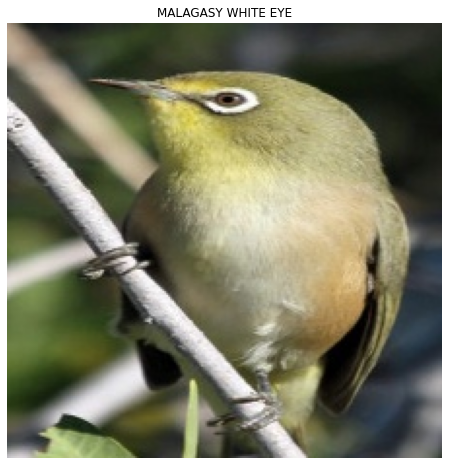

In [16]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

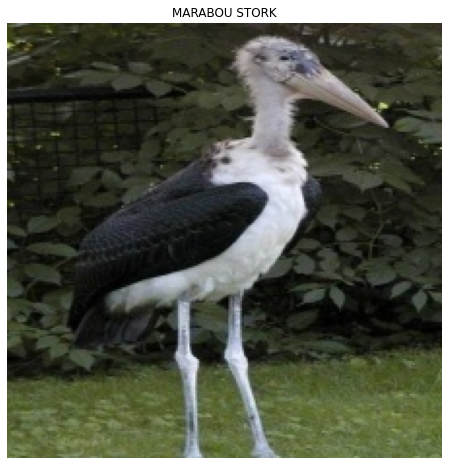

In [17]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

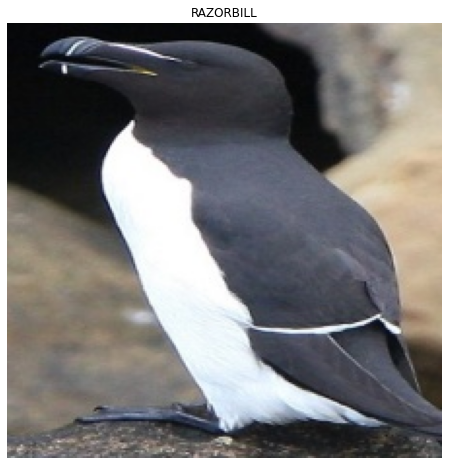

In [18]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

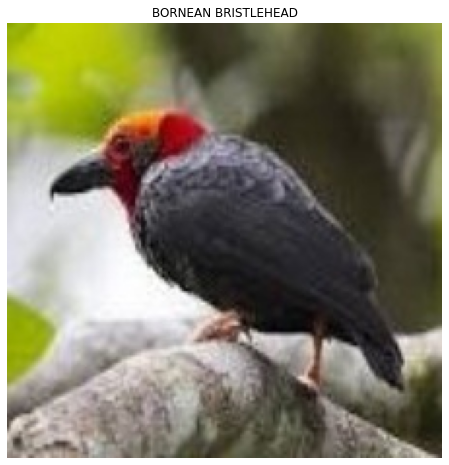

In [19]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

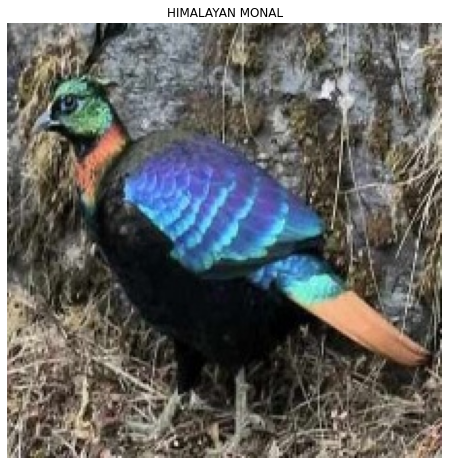

In [20]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

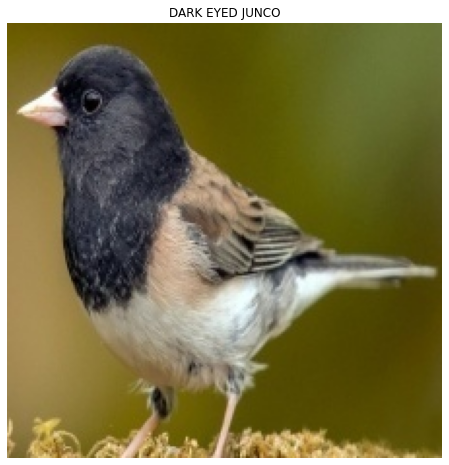

In [21]:
index = np.random.randint(0, num_images)
show_image(df, "data", index)

Let's now check the min and max values of the image pixel values. This is to ensure that the images are later in the range of [0, 1] and are not normalized twice.

In [22]:
def check_min_max_image(df, folder, index):
    filename = os.path.join(folder, df["filepaths"][index])
    
    image = plt.imread(filename)
    print(f"Min: {np.min(image)} | Max: {np.max(image)}")

In [23]:
index = np.random.randint(0, num_images)
check_min_max_image(df, "data", index)

Min: 3 | Max: 206


In [24]:
index = np.random.randint(0, num_images)
check_min_max_image(df, "data", index)

Min: 32 | Max: 255


In [25]:
index = np.random.randint(0, num_images)
check_min_max_image(df, "data", index)

Min: 0 | Max: 255


Okay the images are not already normalized, so we can do this later in the input pipeline.

### Check distribution of data
Let's now check the data distribution. This is to check if there are enough images for each class and to maybe apply some data imbalance strategies for balancing the dataset.

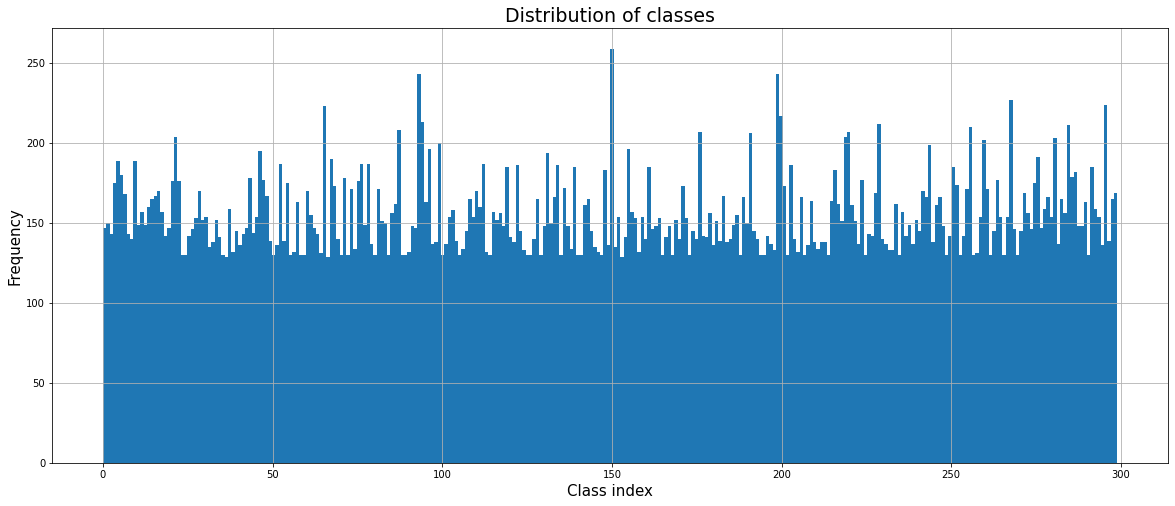

In [26]:
plt.figure(figsize=(20, 8))
df["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

The dataset looks quite balanced. However, some classes seem to have less samples than others, which could result in a worse performance of the model on these classes. Let's later check if balancing can improve the overal performance! <br> <br>
Let's now check the distributions for the training and test set. This is important to ensure that the test set contains a similar distribution than the training set.

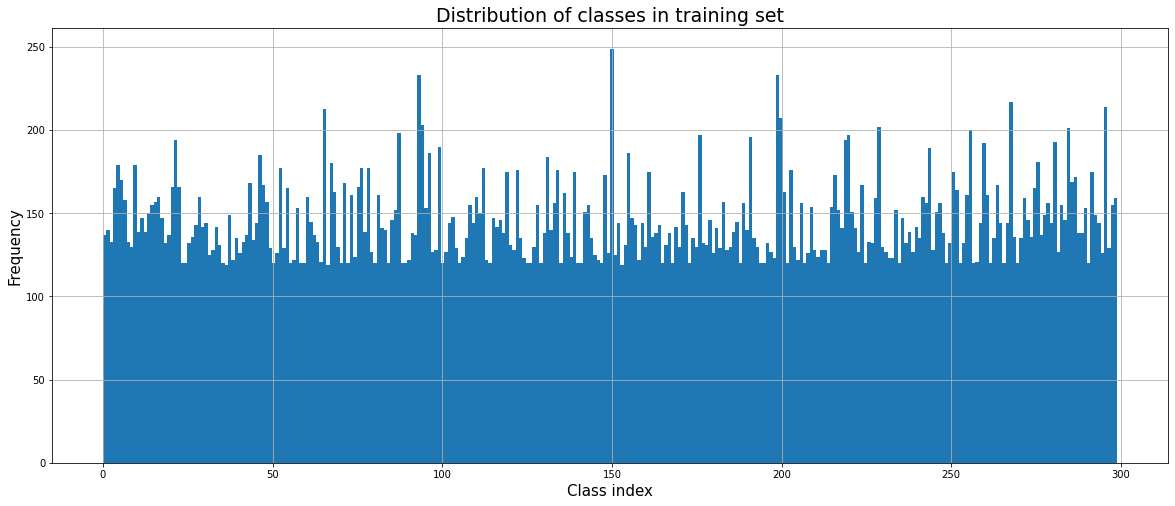

In [27]:
plt.figure(figsize=(20, 8))
df_train["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

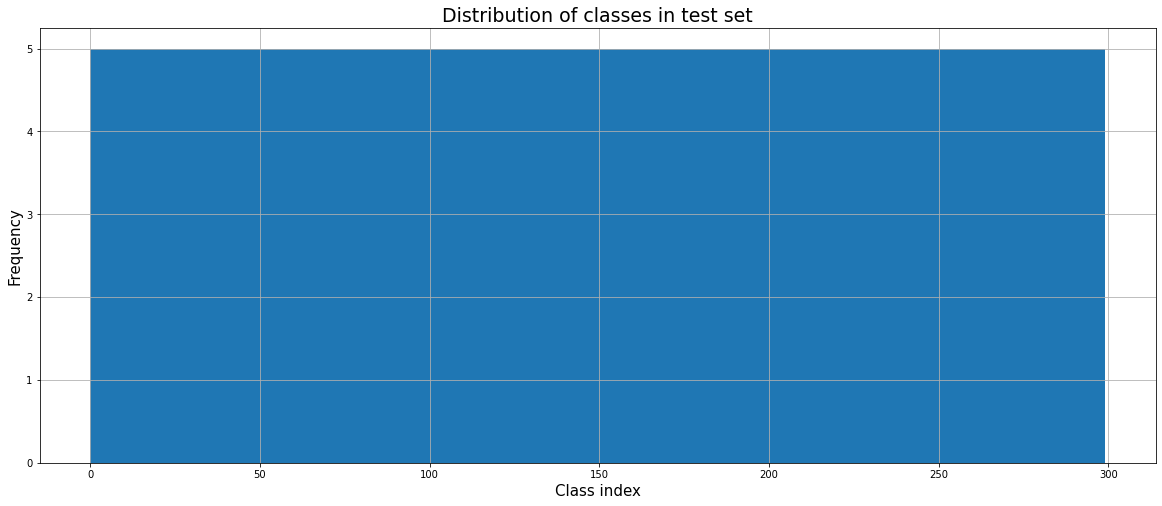

In [28]:
plt.figure(figsize=(20, 8))
df_test["class_index"].hist(bins=len(class_names))
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.show()

Okay. Seems like the test set distribution was created manually and does not reflect the real data distribution. This is bad, because the test set would not reflect the performance on "real world" data. Therefore, let's create new training, validation and test sets by using the StratefiedShuffleSplit of sklearn. <br> <br>
But: Let's first one-hot encode the data such that it has the expected format for the network.

In [29]:
# start with one-hot encoding the column "class"
df_encoded = pd.get_dummies(df, columns=["labels"])
df_encoded.columns = ["filepaths", "data set", "class_index", *class_names]
df_encoded.head()

,filepaths,data set,class_index,AFRICAN CROWNED CRANE,AFRICAN FIREFINCH,ALBATROSS,ALEXANDRINE PARAKEET,AMERICAN AVOCET,AMERICAN BITTERN,AMERICAN COOT,...,WHITE CHEEKED TURACO,WHITE NECKED RAVEN,WHITE TAILED TROPIC,WHITE THROATED BEE EATER,WILD TURKEY,WILSONS BIRD OF PARADISE,WOOD DUCK,YELLOW BELLIED FLOWERPECKER,YELLOW CACIQUE,YELLOW HEADED BLACKBIRD
0,train\AFRICAN CROWNED CRANE\001.jpg,train,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train\AFRICAN CROWNED CRANE\002.jpg,train,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,train\AFRICAN CROWNED CRANE\003.jpg,train,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train\AFRICAN CROWNED CRANE\004.jpg,train,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,train\AFRICAN CROWNED CRANE\005.jpg,train,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# split in train and test
for train_index, test_index in sss.split(df_encoded.drop(columns=class_names), df_encoded[class_names]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_encoded.iloc[train_index]
    df_test = df_encoded.iloc[test_index]

TRAIN: [17472 37641  5948 ...  8901 19201 35495] TEST: [15188 46403 16564 ... 23441 20931  1015]


In [32]:
# split train in train and validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

df_train_tmp = df_train.copy()

for train_index, test_index in sss.split(df_train.drop(columns=class_names), df_train[class_names]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_train_tmp.iloc[train_index]
    df_valid = df_train_tmp.iloc[test_index]

TRAIN: [ 6306 27810 16272 ... 18969 15885   411] TEST: [20892 26753 11348 ... 19998  6475  3100]


In [33]:
# quickly check if number of samples of train + valid + test still matches the total number of samples
assert df_train.shape[0] + df_valid.shape[0] + df_test.shape[0] == df.shape[0], "Number of samples in splits does not match"

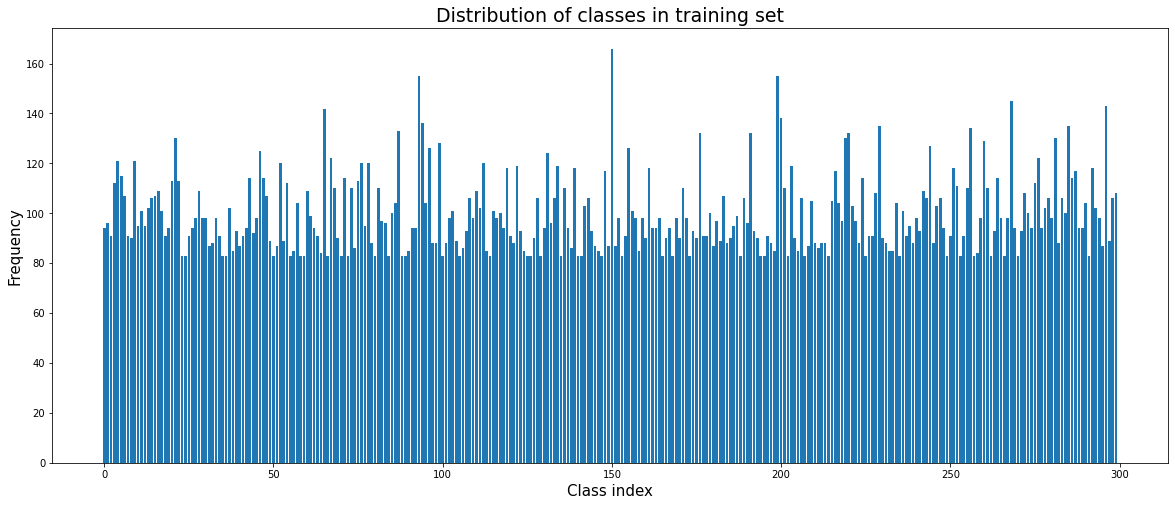

In [34]:
plt.figure(figsize=(20, 8))
count_classes_train = df_train[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.savefig(r"figures\training_set.pdf")
plt.show()

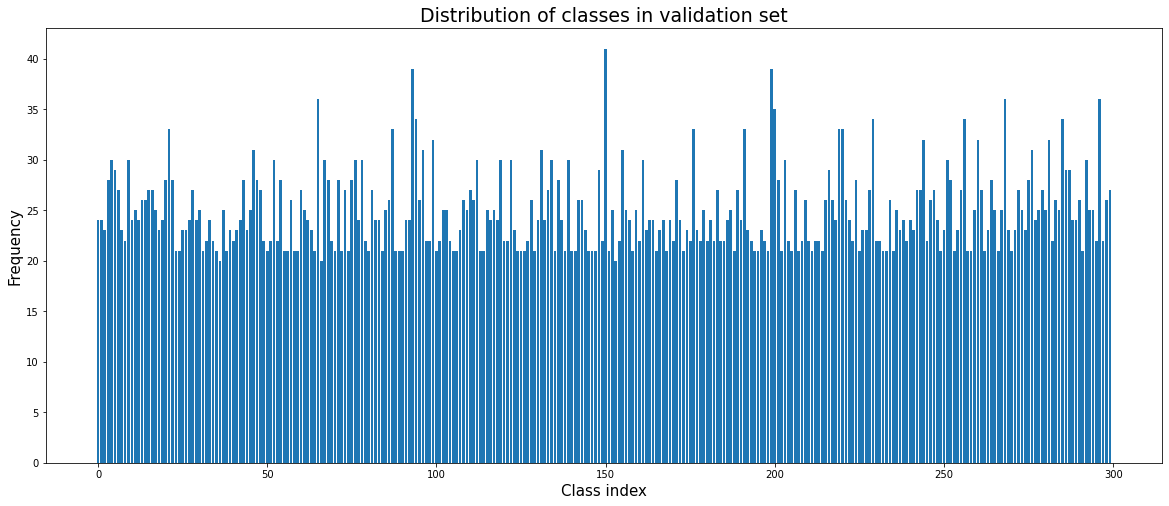

In [35]:
# check distribution of test set
plt.figure(figsize=(20, 8))
count_classes_test = df_valid[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_test)
plt.title("Distribution of classes in validation set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.savefig(r"figures\validation_set.pdf")
plt.show()

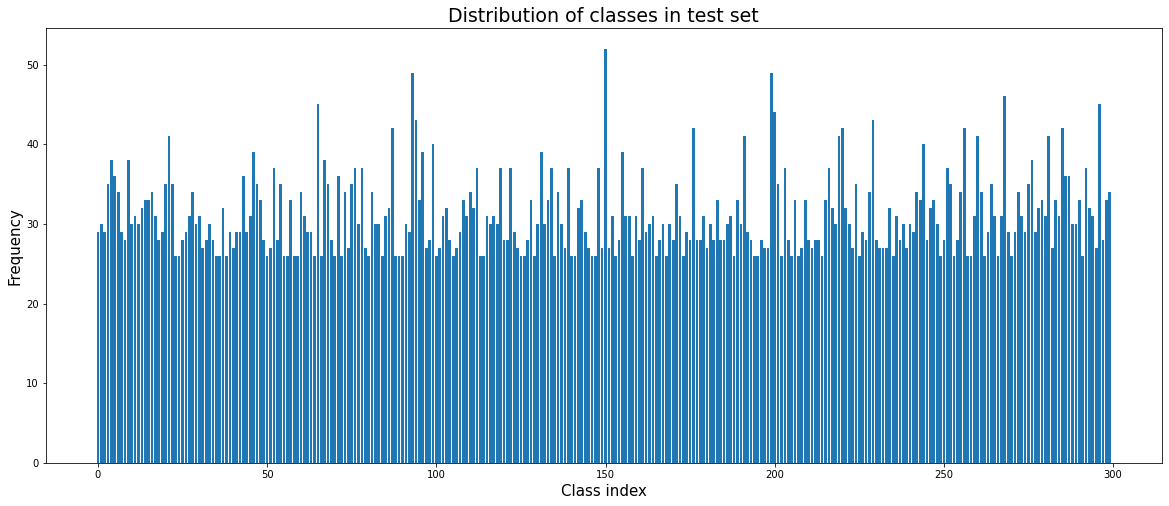

In [36]:
# check distribution of test set
plt.figure(figsize=(20, 8))
count_classes_test = df_test[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_test)
plt.title("Distribution of classes in test set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.savefig(r"figures\test_set.pdf")
plt.show()

Perfect! Now the distributions are all looking the same. Now we can start with creating the input pipeline for training the model.

## Create Tensorflow Input Pipeline

Let's first create a augmentation function that can be used by the image data generator. I selected the augmentations based on some experience and I applied them on an example image of the current dataset in the notebook "Check_Augmentations.ipynb".

In [37]:
import imgaug.augmenters as iaa

def apply_augmentation(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0),
                iaa.Multiply((0.5, 1.5)),
                iaa.SaltAndPepper(0.1),
                [iaa.GammaContrast((0.8, 1.2)),iaa.Add((-60, 60))],
                iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                iaa.MotionBlur(k=10),
                iaa.Affine(scale=(0.5, 1.2)),
                iaa.Rotate((-45, 45)),
                iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0),
              ]                
    for idx, aug in enumerate(aug_list):
        # only apply augmentation such that in total 10% of the images are not augmented
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug))
        rand_nr = np.random.rand()
        threshold = 0.21
        if isinstance(aug, list):
            rand_aug = np.random.randint(0, 2)
            input_image = np.clip(aug[rand_aug](images=input_image), 0., 255.) if rand_nr <= threshold else input_image
        else:
            input_image = np.clip(aug(images=input_image), 0., 255.) if rand_nr <= threshold else input_image

    return np.squeeze(input_image, axis=0)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rescale=1./255, preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

In [75]:
# create datagenerators by calling flow_from_dataframe on them
path_to_images = r"data"
batch_size = 8
shuffle = True
target_size = (224, 224)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_train.columns[3:].tolist(), 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_valid, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_valid.columns[3:].tolist(),  
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

Found 29837 validated image filenames.
Found 7460 validated image filenames.


Now: Check the format in order to ensure that the images are valid when they are entered into the CNN.

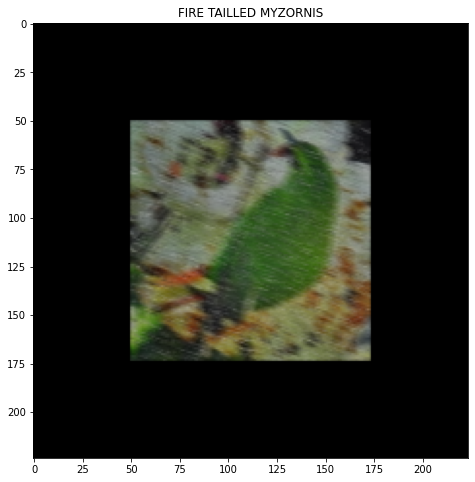

In [76]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

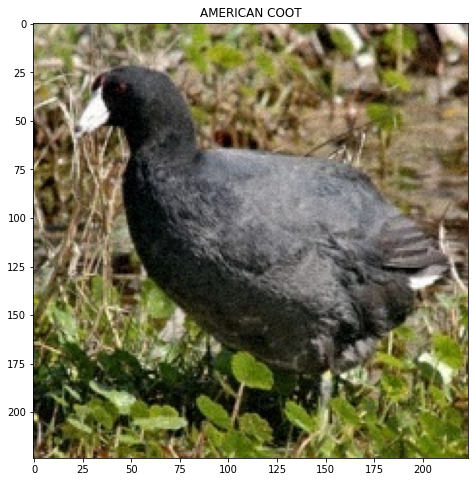

In [77]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

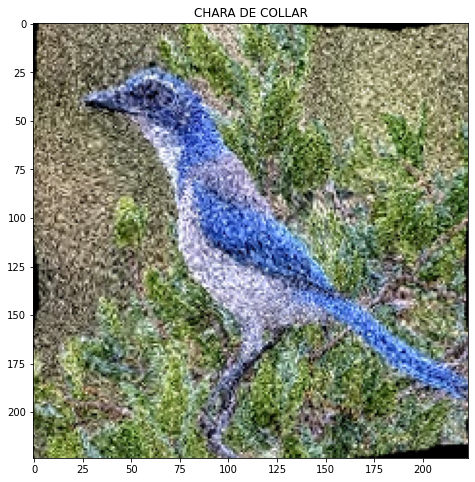

In [78]:
# get random batch and random image from batch
batch_nr = np.random.randint(0, steps_per_epoch_train)
random_img_nr = np.random.randint(0, batch_size)
image = train_generator[batch_nr][0][random_img_nr]
label = train_generator[batch_nr][1][random_img_nr]
plt.title(class_names[np.argmax(label)])
plt.imshow(image)

Let's now build a keras model factory to try out different cnns and use the best performing by considering the trade off between performance and complexity.

In [79]:
class KerasModelFactory():
    '''
    This class can be used to create a keras model and return it.
    '''
    
    def __init__(self):
        '''
        Constructor...
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str)):
                raise ValueError("Input model_name has the wrong datatype!")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "efficientnetb0":
            from tensorflow.keras.applications import EfficientNetB0
            model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "efficientnetb2":
            from tensorflow.keras.applications import EfficientNetB2
            model = EfficientNetB2(weights=weights, include_top=False, input_shape=input_shape)
        elif model_name == "xception":
            from tensorflow.keras.applications import Xception
            model = Xception(weights=weights, include_top=False, input_shape=input_shape)
        else:
            from classification_models.tfkeras import Classifiers
            net, _ = Classifiers.get(model_name)
            model = net(input_shape=input_shape, weights=weights, include_top=False)
            
        # add a global spatial average pooling layer
        # this helps to decrease the risk of overfitting and to plot class activation maps
        x = model.output
        x = keras.layers.GlobalAveragePooling2D()(x)

        # and a fully connected output/classification layer
        predictions = keras.layers.Dense(num_classes, activation=activation_func)(x)

        # create the full network so we can train on it
        model = keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [80]:
# test keras factory
factory = KerasModelFactory()

Let's now compare different cnn encoders and choose the best one by considering the number of trainable parameters and the performance on the validation set. <br>
A cross-validation would be good for choosing the models. However, I decided to not use a cross validation in order to speed up the training process a little bit. <br> <br>
Steps for training the different encoders:
1. Train encoder for 30 epochs and store best validation f1-score of the encoder.
2. Choose best encoder architecture for the remaining part of this project.

In [81]:
encoder_list = ["efficientnetb0", "xception", "densenet121", "resnet18", "resnet34", "resnet50"]
num_epochs = 30
results_dict = dict()
results_hists_dict = dict()
img_height, img_width = target_size
img_depth = 3

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(class_names), 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc"),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = [np.max(hist_dict.history["val_f1_score"]), np.max(hist_dict.history["val_accuracy"])]
    
    # save also the history in order to make some nice visualizations
    results_hists_dict[encoder] = hist_dict.history

Start training efficientnetb0...
Epoch 1/30
3730/3730 [==============================] - 1530s 405ms/step - loss: 4.4338 - accuracy: 0.2047 - auc: 0.7514 - f1_score: 0.0520 - val_loss: 1.3593 - val_accuracy: 0.6751 - val_auc: 0.9828 - val_f1_score: 0.5755
Epoch 2/30
3730/3730 [==============================] - 1095s 294ms/step - loss: 1.0521 - accuracy: 0.7861 - auc: 0.9916 - f1_score: 0.6723 - val_loss: 1.6237 - val_accuracy: 0.6071 - val_auc: 0.9637 - val_f1_score: 0.5642
Epoch 3/30
3730/3730 [==============================] - 1097s 294ms/step - loss: 0.5948 - accuracy: 0.8614 - auc: 0.9957 - f1_score: 0.8409 - val_loss: 0.6097 - val_accuracy: 0.8422 - val_auc: 0.9880 - val_f1_score: 0.8417
Epoch 4/30
3730/3730 [==============================] - 1082s 290ms/step - loss: 0.4314 - accuracy: 0.8960 - auc: 0.9963 - f1_score: 0.8835 - val_loss: 0.7558 - val_accuracy: 0.8050 - val_auc: 0.9844 - val_f1_score: 0.8065
Epoch 5/30
3730/3730 [==============================] - 1095s 294ms/step - 

3730/3730 [==============================] - 1234s 331ms/step - loss: 0.1467 - accuracy: 0.9608 - auc: 0.9993 - f1_score: 0.9597 - val_loss: 0.2015 - val_accuracy: 0.9477 - val_auc: 0.9950 - val_f1_score: 0.9487
Epoch 14/30
3730/3730 [==============================] - 1225s 328ms/step - loss: 0.1355 - accuracy: 0.9644 - auc: 0.9991 - f1_score: 0.9635 - val_loss: 0.1923 - val_accuracy: 0.9515 - val_auc: 0.9957 - val_f1_score: 0.9519
Epoch 15/30
3730/3730 [==============================] - 1230s 330ms/step - loss: 0.1296 - accuracy: 0.9649 - auc: 0.9993 - f1_score: 0.9633 - val_loss: 0.2138 - val_accuracy: 0.9469 - val_auc: 0.9943 - val_f1_score: 0.9492
Epoch 16/30
3730/3730 [==============================] - 1234s 331ms/step - loss: 0.1340 - accuracy: 0.9634 - auc: 0.9993 - f1_score: 0.9633 - val_loss: 0.1910 - val_accuracy: 0.9524 - val_auc: 0.9959 - val_f1_score: 0.9538
Epoch 17/30
3730/3730 [==============================] - 1228s 329ms/step - loss: 0.1206 - accuracy: 0.9664 - auc: 0

3730/3730 [==============================] - 725s 194ms/step - loss: 0.1483 - accuracy: 0.9577 - auc: 0.9987 - f1_score: 0.9586 - val_loss: 0.3189 - val_accuracy: 0.9282 - val_auc: 0.9905 - val_f1_score: 0.9303
Epoch 26/30
3730/3730 [==============================] - 754s 202ms/step - loss: 0.1336 - accuracy: 0.9611 - auc: 0.9988 - f1_score: 0.9629 - val_loss: 0.3149 - val_accuracy: 0.9300 - val_auc: 0.9899 - val_f1_score: 0.9331
Epoch 27/30
3730/3730 [==============================] - 771s 207ms/step - loss: 0.1466 - accuracy: 0.9591 - auc: 0.9984 - f1_score: 0.9600 - val_loss: 0.3269 - val_accuracy: 0.9282 - val_auc: 0.9896 - val_f1_score: 0.9303
Epoch 28/30
3730/3730 [==============================] - 725s 194ms/step - loss: 0.1352 - accuracy: 0.9613 - auc: 0.9986 - f1_score: 0.9615 - val_loss: 0.3349 - val_accuracy: 0.9292 - val_auc: 0.9892 - val_f1_score: 0.9308
Epoch 29/30
3730/3730 [==============================] - 631s 169ms/step - loss: 0.1411 - accuracy: 0.9603 - auc: 0.9982

In [82]:
def create_accuracy_plots(results_hists_dict, figpath=r"figures\encoder_search_accuracy.pdf",
                          num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates an accuracy plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["accuracy"], label="Train")
        plt.plot(hist_dict["val_accuracy"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("Accuracy")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [83]:
def create_loss_plots(results_hists_dict, figpath=r"figures\encoder_search_loss.pdf",
                      num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a loss plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["loss"], label="Train")
        plt.plot(hist_dict["val_loss"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("Loss")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [84]:
def create_f1_plots(results_hists_dict, figpath=r"figures\encoder_search_f1_score.pdf",
                    num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a f1-score plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["f1_score"], label="Train")
        plt.plot(hist_dict["val_f1_score"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("F1-Score")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

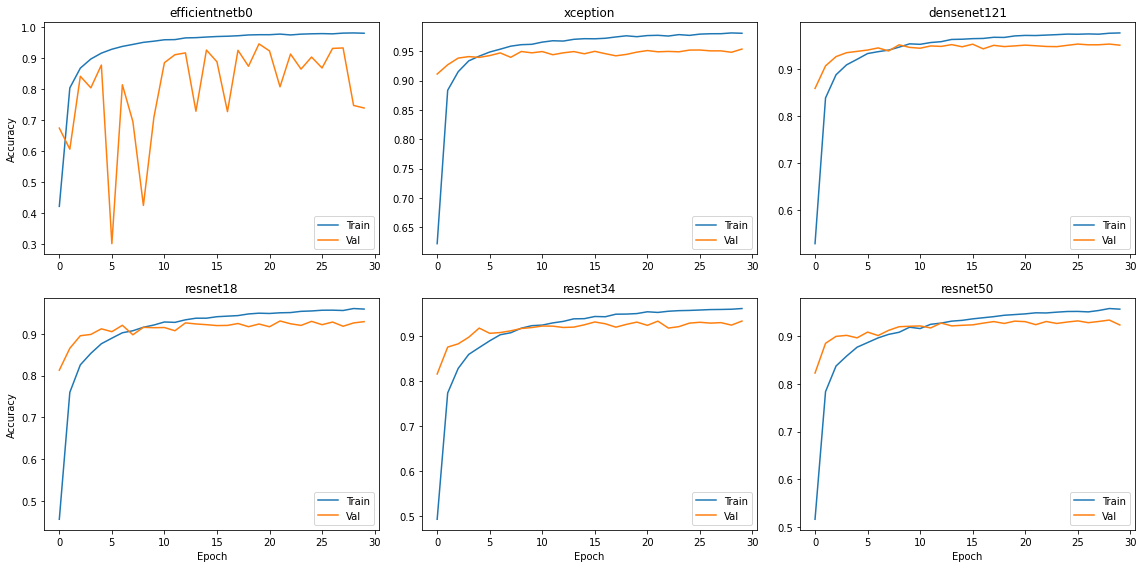

In [85]:
create_accuracy_plots(results_hists_dict)

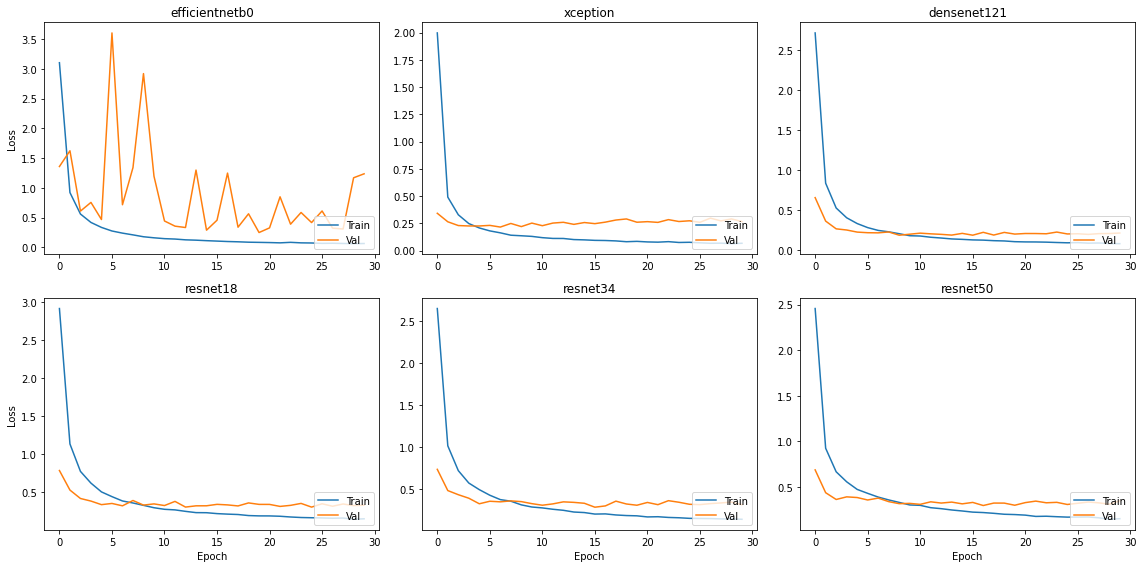

In [86]:
create_loss_plots(results_hists_dict)

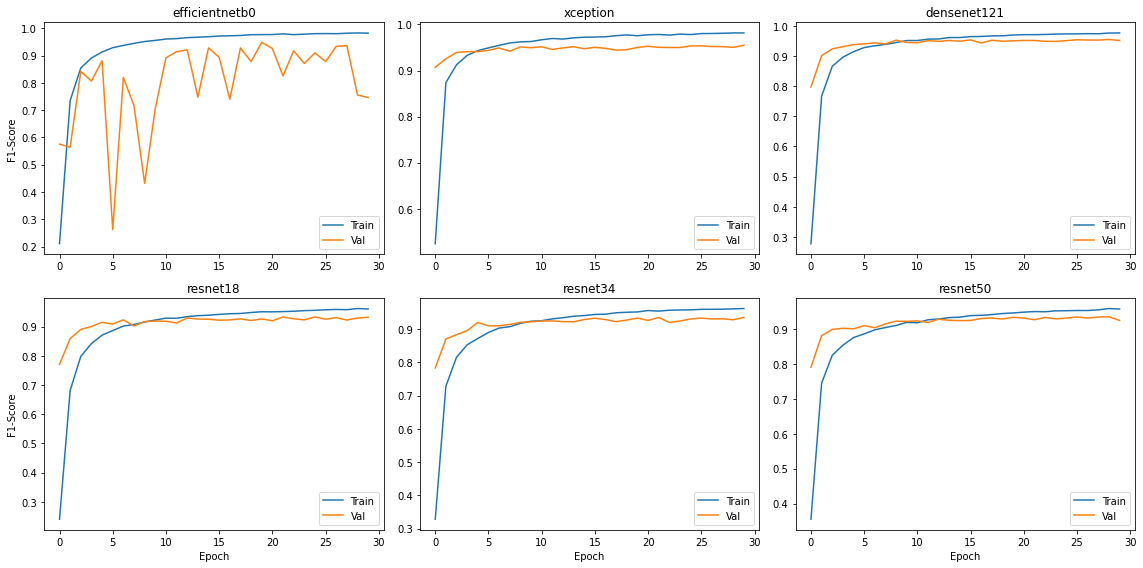

In [87]:
create_f1_plots(results_hists_dict)

In [88]:
(pd.DataFrame
 .from_dict(results_dict, orient="index", columns=["best_val_f1_score", "best_val_accuracy"])
 .sort_values(by=["best_val_f1_score"], ascending=False))

,best_val_f1_score,best_val_accuracy
densenet121,0.955034,0.952681
xception,0.954633,0.953887
efficientnetb0,0.948186,0.946783
resnet50,0.935772,0.933378
resnet34,0.934928,0.932708
resnet18,0.933137,0.930563


The DenseNet121 achieved the best f1-score and is therefore used as the baseline encoder architecture for the remaining part of this project! <br>
There is no gap between the validation and the training curve. This is nice, becasue this means that there is no overfitting!

As a next step, the network shall be trained with different image sizes in order to find the best image size. 

In [98]:
list_image_sizes = [(64, 64), (128, 128), (192, 192), (224, 224)]
num_epochs = 30
encoder = "densenet121"
path_to_images = "data"
batch_size = 8
depth = 3 # using rgb
shuffle = True
img_size_results_dict = dict()
img_size_hists_dict = dict()

for target_size in list_image_sizes:
    print(f"Start training with target size of {target_size}...")
    img_height, img_width = target_size
    
    # setup input pipeline
    datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
    datagen_val = ImageDataGenerator(rescale = 1. / 255)
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                        x_col="filepaths", y_col=df_train.columns[3:].tolist(), 
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)

    valid_generator = datagen_val.flow_from_dataframe(dataframe=df_valid, directory=path_to_images,
                                                        x_col="filepaths", y_col=df_valid.columns[3:].tolist(),  
                                                        batch_size=batch_size, shuffle=shuffle,
                                                        class_mode="raw", target_size=target_size, 
                                                        color_mode="rgb", seed=42)
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(class_names), 
                                                  input_shape=(img_height, img_width, depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.AUC(name="auc"),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)
    
    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)
    
    # get the maximum validation f1-score and validation accuracy and store them
    img_size_results_dict[target_size] = [np.max(hist_dict.history["val_f1_score"]), 
                                          np.max(hist_dict.history["val_accuracy"])]
    
    # add history 
    img_size_hists_dict[target_size] = hist_dict.history

Start training with target size of (64, 64)...
Found 29837 validated image filenames.
Found 7460 validated image filenames.
Epoch 1/30
3730/3730 [==============================] - 1056s 279ms/step - loss: 5.4030 - accuracy: 0.0605 - auc: 0.6597 - f1_score: 0.0110 - val_loss: 2.1469 - val_accuracy: 0.4972 - val_auc: 0.9490 - val_f1_score: 0.3978
Epoch 2/30
3730/3730 [==============================] - 1123s 301ms/step - loss: 2.7372 - accuracy: 0.3946 - auc: 0.9315 - f1_score: 0.2337 - val_loss: 1.3650 - val_accuracy: 0.6568 - val_auc: 0.9727 - val_f1_score: 0.6281
Epoch 3/30
3730/3730 [==============================] - 1122s 301ms/step - loss: 1.9888 - accuracy: 0.5327 - auc: 0.9596 - f1_score: 0.4416 - val_loss: 1.0918 - val_accuracy: 0.7232 - val_auc: 0.9777 - val_f1_score: 0.7161
Epoch 4/30
3730/3730 [==============================] - 1106s 297ms/step - loss: 1.6029 - accuracy: 0.6161 - auc: 0.9694 - f1_score: 0.5740 - val_loss: 0.9576 - val_accuracy: 0.7560 - val_auc: 0.9806 - val_f

3730/3730 [==============================] - 1178s 316ms/step - loss: 0.1838 - accuracy: 0.9498 - auc: 0.9988 - f1_score: 0.9499 - val_loss: 0.2250 - val_accuracy: 0.9412 - val_auc: 0.9954 - val_f1_score: 0.9429
Epoch 13/30
3730/3730 [==============================] - 1177s 316ms/step - loss: 0.1595 - accuracy: 0.9562 - auc: 0.9993 - f1_score: 0.9556 - val_loss: 0.2257 - val_accuracy: 0.9441 - val_auc: 0.9944 - val_f1_score: 0.9480
Epoch 14/30
3730/3730 [==============================] - 1183s 317ms/step - loss: 0.1566 - accuracy: 0.9579 - auc: 0.9989 - f1_score: 0.9583 - val_loss: 0.2393 - val_accuracy: 0.9401 - val_auc: 0.9946 - val_f1_score: 0.9409
Epoch 15/30
3730/3730 [==============================] - 1188s 318ms/step - loss: 0.1463 - accuracy: 0.9617 - auc: 0.9992 - f1_score: 0.9600 - val_loss: 0.2483 - val_accuracy: 0.9353 - val_auc: 0.9939 - val_f1_score: 0.9381
Epoch 16/30
3730/3730 [==============================] - 1181s 317ms/step - loss: 0.1451 - accuracy: 0.9601 - auc: 0

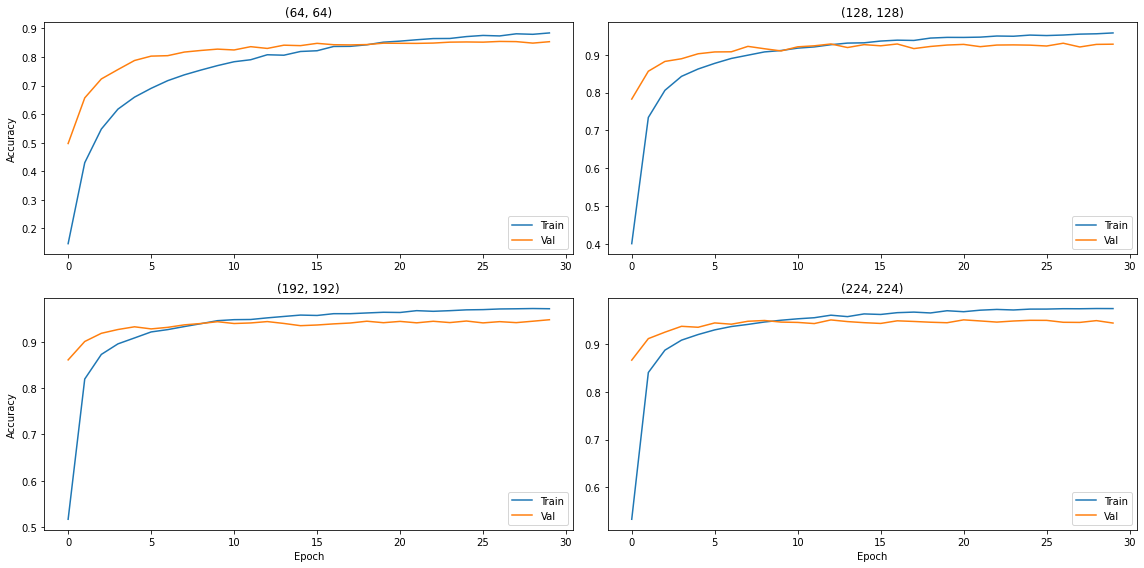

In [99]:
create_accuracy_plots(img_size_hists_dict, figpath=r"figures\image_size_results_accuracy.pdf", 
                      num_rows=2, num_cols=2)

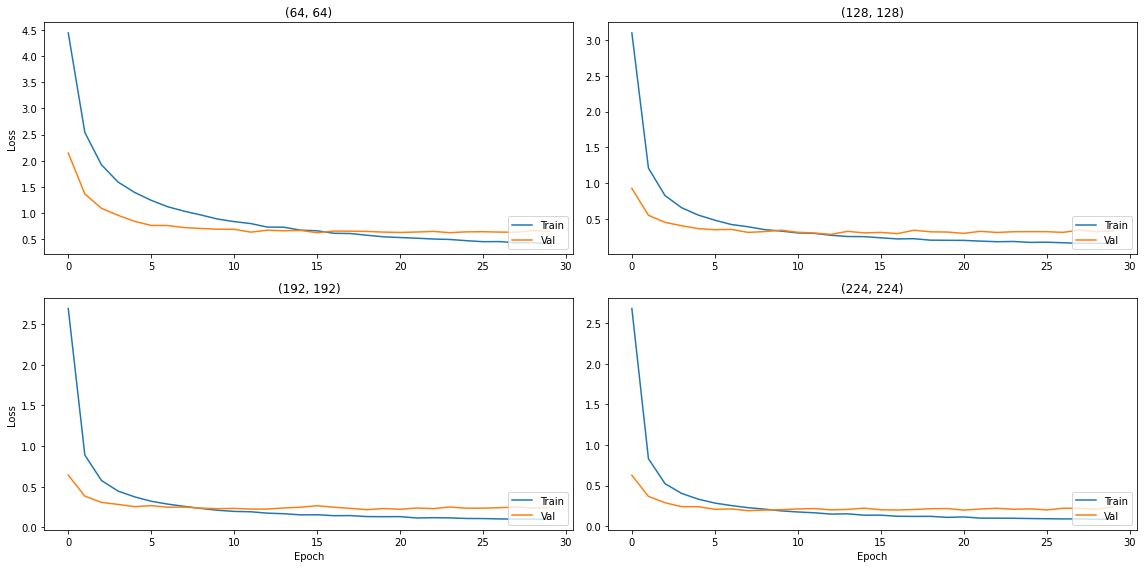

In [100]:
create_loss_plots(img_size_hists_dict, figpath=r"figures\image_size_results_loss.pdf", 
                      num_rows=2, num_cols=2)

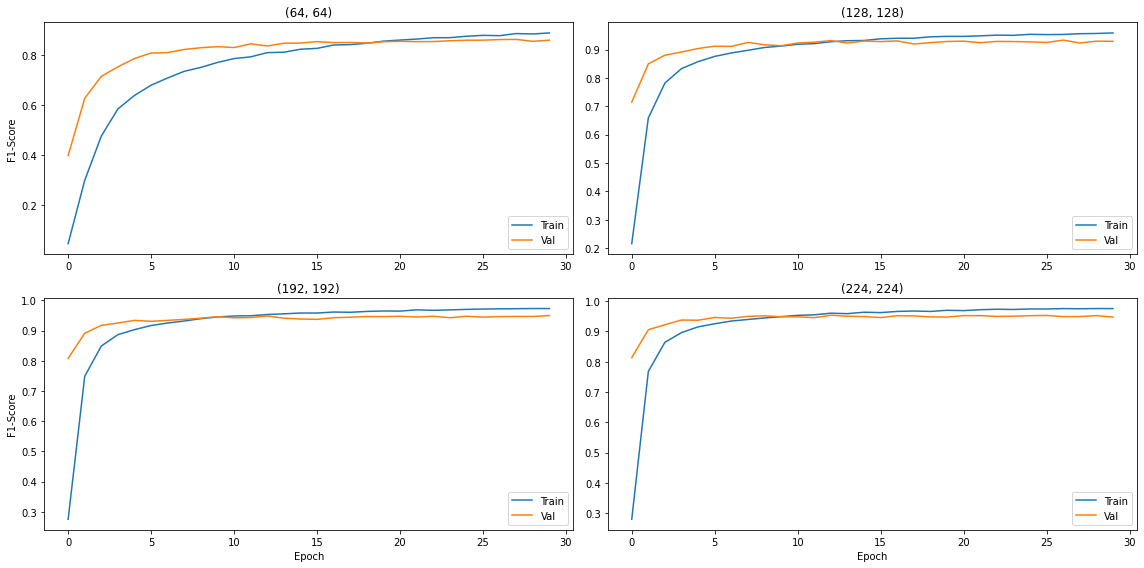

In [101]:
create_f1_plots(img_size_hists_dict, figpath=r"figures\image_size_results_f1_score.pdf", 
                      num_rows=2, num_cols=2)

In [102]:
(pd.DataFrame
 .from_dict(img_size_results_dict, orient="index", columns=["best_val_f1_score", "best_val_accuracy"])
 .sort_values(by=["best_val_f1_score"], ascending=False))

,best_val_f1_score,best_val_accuracy
"(224, 224)",0.953626,0.951340
"(192, 192)",0.949548,0.948123
"(128, 128)",0.933792,0.930429
"(64, 64)",0.864319,0.854558


As one would have guessed: The larger the images, the better the performance of the model. From image size 192x192 to 224x224, there is only a 0.3% increase in accuracy. Therefore, I decided to use this image size in order to speed up the training process a little bit. <br><br> 
Perfect. Now we also have our optimal image size. Let's now continue and check whether we should apply some oversampling to balance the dataset or not. <br> <br>
Important: Oversampling should only be applied on the training set and not on the overal dataset! This is to ensure that no images of the training set are also in the validation or even worse in the test set!

In [103]:
def oversample_dataframe(df):
    # create copy of dataframe
    df_copy = df.copy()
    
    # find majortiy class count
    count_majority = df_copy[df_copy.columns[3:]].sum().max()
    
    # loop over all classes and oversample until count_majority number of samples are reached
    balanced_columns_list = list()
    for col in df_copy.columns[3:]:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_1 = df_copy[df_copy[col] == 1]
        # get the number of samples within that class
        count_class_1 = df_class_1.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_oversampled = df_class_1.sample(count_majority - count_class_1, replace=True)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(pd.concat([df_class_1, df_oversampled]))
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

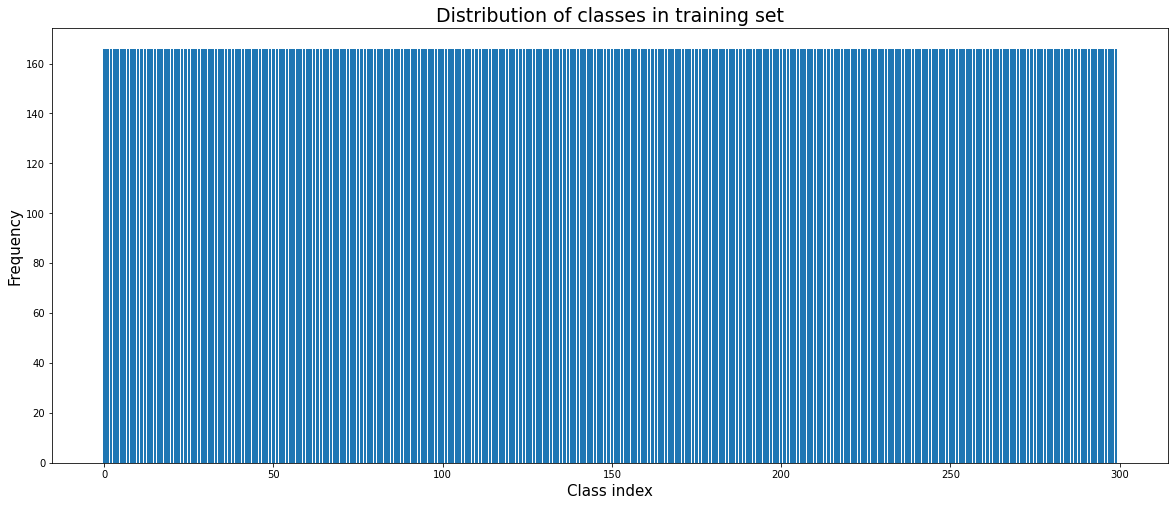

In [104]:
df_train_oversampled = oversample_dataframe(df_train)

plt.figure(figsize=(20, 8))
count_classes_train = df_train_oversampled[class_names].sum(axis=0).values
bins = np.arange(0, len(class_names))
plt.bar(x=bins, height=count_classes_train)
plt.title("Distribution of classes in training set", size=19)
plt.xlabel("Class index", size=15)
plt.ylabel("Frequency", size=15)
plt.savefig(r"figures\oversampled_dataset.pdf")
plt.show()

That looks good. Now we have a fully balanced dataframe. Let's now create the training loop for comparing the fully balanced to the imbalanced training. <br> 
We only have to train the oversampling case, because we can reuse the results from the network with our new target image size as the results for the imbalanced learning.

In [106]:
target_image_size = (192, 192)
img_height, img_width = target_image_size
num_epochs = 20
encoder = "densenet121"
path_to_images = "data"
batch_size = 8
depth = 3 # using rgb
oversampling_results = list()

# setup input pipeline
datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train_oversampled, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_train_oversampled.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_valid, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_valid.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=len(class_names), 
                                              input_shape=(img_height, img_width, depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# define the metrics
metrics_list = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
]

# compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

# fit the model for num_epochs epochs
with tf.device("/GPU:0"):
    hist_dict = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)

# get the maximum validation f1-score and validation accuracy and store them
oversampling_results = [np.max(hist_dict.history["val_f1_score"]), 
                        np.max(hist_dict.history["val_accuracy"])]

Found 49800 validated image filenames.
Found 7460 validated image filenames.
Epoch 1/20
6225/6225 [==============================] - 1979s 316ms/step - loss: 3.3385 - accuracy: 0.4255 - auc: 0.8718 - f1_score: 0.2079 - val_loss: 0.3971 - val_accuracy: 0.9066 - val_auc: 0.9969 - val_f1_score: 0.8940
Epoch 2/20
6225/6225 [==============================] - 1961s 315ms/step - loss: 0.5716 - accuracy: 0.8830 - auc: 0.9971 - f1_score: 0.8465 - val_loss: 0.3107 - val_accuracy: 0.9162 - val_auc: 0.9958 - val_f1_score: 0.9193
Epoch 3/20
6225/6225 [==============================] - 1953s 314ms/step - loss: 0.3391 - accuracy: 0.9247 - auc: 0.9981 - f1_score: 0.9137 - val_loss: 0.2411 - val_accuracy: 0.9349 - val_auc: 0.9960 - val_f1_score: 0.9345
Epoch 4/20
6225/6225 [==============================] - 1951s 313ms/step - loss: 0.2536 - accuracy: 0.9407 - auc: 0.9983 - f1_score: 0.9365 - val_loss: 0.2295 - val_accuracy: 0.9406 - val_auc: 0.9956 - val_f1_score: 0.9406
Epoch 5/20
6225/6225 [=========

In [107]:
print(f"Oversampling f1-score: {oversampling_results[0]} | Oversampling accuracy: {oversampling_results[1]}")

Oversampling f1-score: 0.954483151435852 | Oversampling accuracy: 0.9517426490783691


Okay. Seems like oversampling doesn't bring any boost here. It only increases the training time per epoch. Therefore, I am not going to use oversampling for the final model! <br> <br>
Now let's come to the last evaluation step: Searching good hyperparameters using Bayesian Hyperparameter search. But let's now only train for 20 epochs in order to speed the training process up a little bit. This should be fine, because when you take a look at the training curves of the densenet121, then you can see that there was no real boost of training performance after 20 epochs and the loss curve is quite flat between 20 and 30 epochs.

In [109]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from skopt.callbacks import CheckpointSaver

In [110]:
# create hyperparameter search space

dim_learning_rate = Real(low=1e-5, high=1e-3, prior='log-uniform', name='learning_rate')
dim_batch_size = Categorical([8, 16], name='batch_size')
dim_optimizer = Categorical(categories=["Adam", "RMSProp"], name="optimizer")
dim_decay = Real(low=0.95, high=1, name="decay_rate")
dim_steps_multiplier = Real(low=1, high=3, name="decay_steps")

dimensions = [dim_learning_rate,
              dim_batch_size,
              dim_optimizer,
              dim_decay,
              dim_steps_multiplier]

default_parameters = [[1e-4, 16, "Adam", 1, 3],
                      [1e-3, 16, "Adam", 0.95, 3],
                      [1e-4, 16, "RMSProp", 1, 3],
                      [1e-3, 16, "RMSProp", 0.95, 3]
                     ]

In [111]:
# let's write a create model function to easily return the keras model with all required parameters and setup

def create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train, encoder, new_class_names):
    
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=len(class_names), 
                                                  input_shape=(192, 192, 3),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    initial_learning_rate = learning_rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps= int(decay_steps * steps_per_epoch_train),
                                                                 decay_rate=decay_rate,
                                                                 staircase=True)
        
    if optimizer == "RMSProp":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule,
                                                       rho=0.9, momentum=0.9, name="RMSprop")
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name="Adam")
        
    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(),
        keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=len(class_names), average='weighted',threshold=0.5),
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics_list)
    
    return model

In [112]:
# let's now create the fitness function that shall be optimized

def create_fitness_func(encoder, class_names, num_epochs):

    @use_named_args(dimensions=dimensions)
    def fitness(learning_rate, batch_size, optimizer, decay_rate, decay_steps):
        
        print(f"Start with evaluating: lr: {learning_rate} | batch size: {batch_size} | optimizer: {optimizer} \
        decay rate: {decay_rate} | decay steps: {decay_steps}")
        
        # create data generators in order to load the images
        datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
        datagen_val = ImageDataGenerator(rescale = 1. / 255)

        train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                            x_col="filepaths", y_col=df_train.columns[3:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        valid_generator = datagen_val.flow_from_dataframe(dataframe=df_valid, directory=path_to_images,
                                                            x_col="filepaths", y_col=df_valid.columns[3:], 
                                                            batch_size=batch_size, shuffle=shuffle,
                                                            class_mode="raw", target_size=target_size, 
                                                            color_mode="rgb", seed=42)

        # set parameters for learning
        steps_per_epoch_train = train_generator.__len__()
        steps_per_epoch_val = valid_generator.__len__()

        # create model
        model = create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train,
                             encoder, class_names)

        history = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator)

        f1_score = np.amax(history.history["val_f1_score"])

        if np.isnan(f1_score):
            f1_score = -1.0

        print(f"\nBest Validation F1-Score: {f1_score}\n")

        # delete model from memory
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
        tf.compat.v1.reset_default_graph()

        # the optimizer aims for the lowest score, so return negative f1_score
        return -f1_score
    return fitness

In [114]:
encoder = "densenet121"
num_epochs = 20

gp_result = gp_minimize(func=create_fitness_func(encoder, class_names, num_epochs),
                        dimensions=dimensions,
                        n_calls=12,
                        n_jobs=-1,
                        acq_func="LCB",
                        kappa = 3,
                        n_initial_points=0,
                        x0=default_parameters,
                        verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
Start with evaluating: lr: 0.0001 | batch size: 16 | optimizer: Adam         decay rate: 1 | decay steps: 3
Found 29837 validated image filenames.
Found 7460 validated image filenames.
Epoch 1/20
1865/1865 [==============================] - 739s 389ms/step - loss: 4.0069 - categorical_accuracy: 0.3169 - auc: 0.8188 - f1_score: 0.0894 - val_loss: 0.7306 - val_categorical_accuracy: 0.8775 - val_auc: 0.9967 - val_f1_score: 0.7730
Epoch 2/20
1865/1865 [==============================] - 692s 371ms/step - loss: 0.8763 - categorical_accuracy: 0.8514 - auc: 0.9948 - f1_score: 0.7355 - val_loss: 0.3717 - val_categorical_accuracy: 0.9240 - val_auc: 0.9973 - val_f1_score: 0.9050
Epoch 3/20
1865/1865 [==============================] - 724s 388ms/step - loss: 0.4746 - categorical_accuracy: 0.9056 - auc: 0.9979 - f1_score: 0.8744 - val_loss: 0.2942 - val_categorical_accuracy: 0.9279 - val_auc: 0.9966 - val_f1_score: 0.9229
Epoch 4/20
18

1865/1865 [==============================] - 702s 376ms/step - loss: 3.7492 - categorical_accuracy: 0.1955 - auc: 0.8715 - f1_score: 0.0781 - val_loss: 3.7451 - val_categorical_accuracy: 0.2331 - val_auc: 0.8545 - val_f1_score: 0.1533
Epoch 4/20
1865/1865 [==============================] - 728s 390ms/step - loss: 3.1206 - categorical_accuracy: 0.3018 - auc: 0.9067 - f1_score: 0.1821 - val_loss: 2.7309 - val_categorical_accuracy: 0.3865 - val_auc: 0.9152 - val_f1_score: 0.3038
Epoch 5/20
1865/1865 [==============================] - 704s 377ms/step - loss: 2.6495 - categorical_accuracy: 0.3951 - auc: 0.9263 - f1_score: 0.2998 - val_loss: 2.7437 - val_categorical_accuracy: 0.3925 - val_auc: 0.9104 - val_f1_score: 0.3293
Epoch 6/20
1865/1865 [==============================] - 731s 392ms/step - loss: 2.3158 - categorical_accuracy: 0.4695 - auc: 0.9385 - f1_score: 0.3941 - val_loss: 2.3322 - val_categorical_accuracy: 0.4871 - val_auc: 0.9268 - val_f1_score: 0.4465
Epoch 7/20
1865/1865 [=====

3730/3730 [==============================] - 1195s 320ms/step - loss: 3.3218 - categorical_accuracy: 0.2487 - auc: 0.9075 - f1_score: 0.0974 - val_loss: 2.8972 - val_categorical_accuracy: 0.3638 - val_auc: 0.9119 - val_f1_score: 0.2570
Epoch 4/20
3730/3730 [==============================] - 1220s 327ms/step - loss: 2.5262 - categorical_accuracy: 0.4129 - auc: 0.9383 - f1_score: 0.2869 - val_loss: 2.0580 - val_categorical_accuracy: 0.5186 - val_auc: 0.9456 - val_f1_score: 0.4489
Epoch 5/20
3730/3730 [==============================] - 1216s 326ms/step - loss: 2.0769 - categorical_accuracy: 0.5018 - auc: 0.9533 - f1_score: 0.4252 - val_loss: 1.7111 - val_categorical_accuracy: 0.5918 - val_auc: 0.9584 - val_f1_score: 0.5617
Epoch 6/20
3730/3730 [==============================] - 1226s 329ms/step - loss: 1.7703 - categorical_accuracy: 0.5722 - auc: 0.9616 - f1_score: 0.5173 - val_loss: 1.4570 - val_categorical_accuracy: 0.6464 - val_auc: 0.9659 - val_f1_score: 0.6233
Epoch 7/20
3730/3730 [=

Epoch 4/20
1865/1865 [==============================] - 728s 390ms/step - loss: 0.2951 - categorical_accuracy: 0.9328 - auc: 0.9981 - f1_score: 0.9269 - val_loss: 0.2509 - val_categorical_accuracy: 0.9371 - val_auc: 0.9968 - val_f1_score: 0.9367
Epoch 5/20
1865/1865 [==============================] - 684s 366ms/step - loss: 0.2361 - categorical_accuracy: 0.9437 - auc: 0.9983 - f1_score: 0.9406 - val_loss: 0.2249 - val_categorical_accuracy: 0.9412 - val_auc: 0.9967 - val_f1_score: 0.9437
Epoch 6/20
1865/1865 [==============================] - 699s 375ms/step - loss: 0.2090 - categorical_accuracy: 0.9492 - auc: 0.9986 - f1_score: 0.9481 - val_loss: 0.2106 - val_categorical_accuracy: 0.9446 - val_auc: 0.9967 - val_f1_score: 0.9458
Epoch 7/20
1865/1865 [==============================] - 717s 385ms/step - loss: 0.1756 - categorical_accuracy: 0.9570 - auc: 0.9991 - f1_score: 0.9556 - val_loss: 0.2033 - val_categorical_accuracy: 0.9495 - val_auc: 0.9959 - val_f1_score: 0.9488
Epoch 8/20
1865/

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

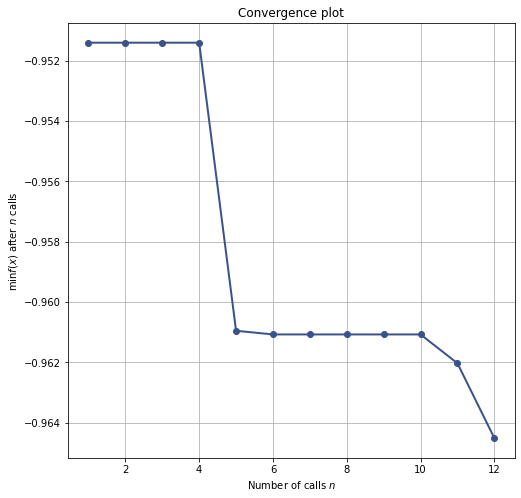

In [115]:
from skopt.plots import plot_convergence
plot_convergence(gp_result)

In [116]:
stacked_results = np.hstack(( np.array(gp_result.x_iters), np.expand_dims(np.array((-1)*gp_result.func_vals), axis=1) ))

In [117]:
pd.DataFrame(stacked_results, columns=["learning rate", "batch size", "optimizer", "decay rate", "decay steps", "f1-score"])

,learning rate,batch size,optimizer,decay rate,decay steps,f1-score
0,0.0001,16,Adam,1,3,0.9514085650444031
1,0.001,16,Adam,0.95,3,0.8576197624206543
2,0.0001,16,RMSProp,1,3,0.859584629535675
3,0.001,16,RMSProp,0.95,3,0.7536594867706299
4,2.877967288534721e-05,16,Adam,0.9986665999693007,2.4364873803200533,0.9609510898590088
5,1.2845104666558906e-05,8,Adam,0.9858332981402353,1.1367056994122728,0.9610726237297058
6,0.001,8,Adam,1.0,1.0,0.8185916543006897
7,1e-05,8,RMSProp,0.95,3.0,0.9603657126426697
8,1e-05,8,Adam,0.95,3.0,0.9561067223548889
9,1e-05,16,RMSProp,1.0,1.0,0.9553728699684143


Okay perfect! Now a good fit for the hyperparameters is found. Now the final model can finally be trained! <br> <br>
I like to train the final model for a certain fixed number of epochs, where always the best model according to the validation f1-score is stored. Another option is to use early stopping. But I'm personal not a fan of early stopping, because it could also stop too early when the amount of epochs without improvement is set too low.

## Final Model Training

In [121]:
encoder = "densenet121"
num_epochs = 30
target_size = (192, 192)

# create data generators in order to load the images
datagen_train = ImageDataGenerator(rescale=1./255,preprocessing_function=apply_augmentation)
datagen_val = ImageDataGenerator(rescale = 1. / 255)

train_generator = datagen_train.flow_from_dataframe(dataframe=df_train, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_train.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

valid_generator = datagen_val.flow_from_dataframe(dataframe=df_valid, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_valid.columns[3:], 
                                                    batch_size=batch_size, shuffle=shuffle,
                                                    class_mode="raw", target_size=target_size, 
                                                    color_mode="rgb", seed=42)

# set parameters for learning
steps_per_epoch_train = train_generator.__len__()
steps_per_epoch_val = valid_generator.__len__()

# get best parameters
learning_rate, batch_size, optimizer, decay_rate, decay_steps = gp_result.x

# create the callback for storing the best model
path_to_store = r"model\best_model_{epoch:02d}_{val_f1_score:.3f}"
save_bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_to_store, 
                                                           save_weights_only=False, 
                                                           verbose=1,
                                                           monitor="val_f1_score", 
                                                           save_best_only=True, 
                                                           mode="max")

# create model
model = create_model(learning_rate, optimizer, decay_rate, decay_steps, steps_per_epoch_train,
                     encoder, class_names)

history = model.fit(train_generator, epochs=num_epochs, verbose=1, validation_data=valid_generator,
                    callbacks=save_bestmodel_callback)

Found 29837 validated image filenames.
Found 7460 validated image filenames.
Epoch 1/30
3730/3730 [==============================] - 1205s 319ms/step - loss: 4.7843 - categorical_accuracy: 0.1746 - auc: 0.7417 - f1_score: 0.0103 - val_loss: 1.1973 - val_categorical_accuracy: 0.7874 - val_auc: 0.9919 - val_f1_score: 0.5830

Epoch 00001: val_f1_score improved from -inf to 0.58305, saving model to model\best_model_01_0.583
INFO:tensorflow:Assets written to: model\best_model_01_0.583\assets
Epoch 2/30
3730/3730 [==============================] - 1187s 318ms/step - loss: 1.7360 - categorical_accuracy: 0.7311 - auc: 0.9891 - f1_score: 0.3583 - val_loss: 0.5268 - val_categorical_accuracy: 0.8918 - val_auc: 0.9965 - val_f1_score: 0.8550

Epoch 00002: val_f1_score improved from 0.58305 to 0.85495, saving model to model\best_model_02_0.855
INFO:tensorflow:Assets written to: model\best_model_02_0.855\assets
Epoch 3/30
3730/3730 [==============================] - 1198s 321ms/step - loss: 0.9061 - 

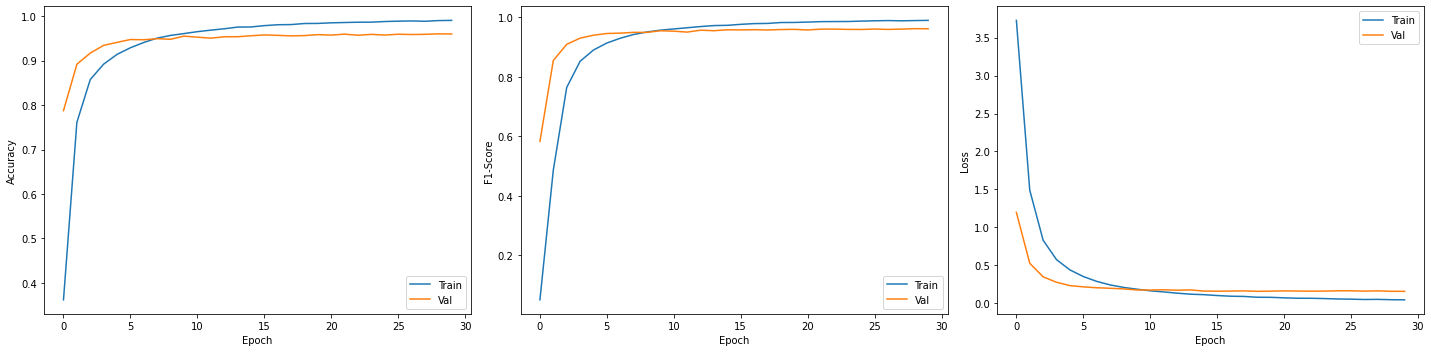

In [122]:
figpath = r"figures\final_model_results.pdf"
fig = plt.figure(figsize = (20, 5))
hist_dict = history.history
    
plt.subplot(1, 3, 1)
plt.plot(hist_dict["categorical_accuracy"], label="Train")
plt.plot(hist_dict["val_categorical_accuracy"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 3, 2)
plt.plot(hist_dict["f1_score"], label="Train")
plt.plot(hist_dict["val_f1_score"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(hist_dict["loss"], label="Train")
plt.plot(hist_dict["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(figpath)
plt.show()

The best model was found in epoch 29 with a validation f1-score of 96.2 percentage.

In [124]:
# load best model
path = r"model\final_model"
final_model = tf.keras.models.load_model(path)
target_size = (192, 192)

# set up test data pipeline
datagen_test = ImageDataGenerator(rescale = 1. / 255)
test_generator = datagen_test.flow_from_dataframe(dataframe=df_test, directory=path_to_images,
                                                    x_col="filepaths", y_col=df_test.columns[3:], 
                                                    batch_size=8, class_mode="raw", 
                                                    target_size=target_size, 
                                                    color_mode="rgb", seed=42)


# evaluate model on test set
test_results_dict = final_model.evaluate(x=test_generator, verbose=1, return_dict=True)

Found 9325 validated image filenames.
1166/1166 [==============================] - 292s 248ms/step - loss: 0.1710 - categorical_accuracy: 0.9579 - auc: 0.9955 - f1_score: 0.9591


Very nice! The trained final model achieves a f1-score of almost 96%! This shows that the model has learned the underlying task and data very well and performs good in the real world.